In [6]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

데이터 불러오기

In [8]:
data_path= "../data"
signal_name = 'signal2_X8'
file_num = 100 # 들고올 파일의 개수
csv_cnt ={1:"*999.csv",10:"*99.csv",100:"*9.csv",1000:".csv"} # 하나의 종류에 파일이 총 100개일 때 
normal_files = glob.glob(data_path+'/'+signal_name+'/normal/'+csv_cnt[file_num])
anormal_drift_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/drift/'+csv_cnt[file_num])
anormal_erratic_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/erratic/'+csv_cnt[file_num])
anormal_hardover_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/hardover/'+csv_cnt[file_num])
anormal_spike_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/spike/'+csv_cnt[file_num])
anormal_stuck_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/stuck/'+csv_cnt[file_num])
#print(anormal_drift_files)

def dataReader(path_names):
    data_n = pd.DataFrame() #판다스의 데이터프레임 형태로 프레임 생성
    for i in path_names:
        low_data = pd.read_csv(i)# 판다스 형태로 읽음, 한csv파일씩 읽기 떄문에 다음 라인에서 하나로 합침
        data_n = pd.concat([data_n,low_data],ignore_index=True)
    return data_n

normal_datas = dataReader(normal_files)
drift_datas = dataReader(anormal_drift_files)
erratic_datas = dataReader(anormal_erratic_files)
hardover_datas = dataReader(anormal_hardover_files)
spike_datas = dataReader(anormal_spike_files)
stuck_datas = dataReader(anormal_stuck_files)
#print(drift_datas)

data shape 변경

In [9]:
#LSTM, LSTM-AE
def X_to_XyLSTM_shape(X,ntime_in,ntime_after): #X변형할 시계열 데이터 n_time_in 만큼 하나의 input으로 봄, ntime_out만큼 뒤에꺼를 예측
    nsample = len(X) - ntime_in -ntime_after 
    X_ntime = [0 for _ in range(nsample)]
    for i in range(nsample):
        X_ntime[i] = X[i:i+ntime_in]
    X_train = np.reshape(X_ntime,(nsample,ntime_in,1)) #2차원 배열을 3차원 배열으로
    #print('X',X_train.shape)
    y_nfuture = [0 for _ in range(nsample)]
    for i in range(nsample):
        after = i+ntime_in+ntime_after-1 # 배열 시작값이므로 -1
        y_nfuture[i] = X[after:after+1].values.flatten()
    y_train = np.array(y_nfuture)
    #print('y',y_train.shape)
    return X_train,y_train

모델생성

In [10]:
from tensorflow.python.keras.layers import InputLayer, Dense, LSTM
from tensorflow.python.keras.models import Sequential

n_time_in = 128 #128개의 데이터 입력으로 받음
ntime_after = 1 # ntime 후 값 예측

#LSTM_signal1 모델
LSTM_model_signal1 = Sequential()
LSTM_model_signal1.add(LSTM(128, input_shape=(n_time_in, 1)))
LSTM_model_signal1.add(Dense(1))
LSTM_model_signal1.compile(loss="mean_squared_error",optimizer='adam')


학습

In [11]:
series_data = normal_datas
X_LSTM_train, y_LSTM_train = X_to_XyLSTM_shape(series_data['value'],n_time_in,ntime_after)
"""
#datashape 변경확인
i= 5
print("X\n",X_LSTM_train[i])
print("y\n",y_LSTM_train[i])
print("series_data\n",series_data['value'][i+(n_time_in+ntime_after)-1]) #인덱스 이므로 -1
"""

'\n#datashape 변경확인\ni= 5\nprint("X\n",X_LSTM_train[i])\nprint("y\n",y_LSTM_train[i])\nprint("series_data\n",series_data[\'value\'][i+(n_time_in+ntime_after)-1]) #인덱스 이므로 -1\n'

In [13]:
LSTM_model_signal1.fit(X_LSTM_train,y_LSTM_train,epochs=1,batch_size=100,verbose=0)

추론

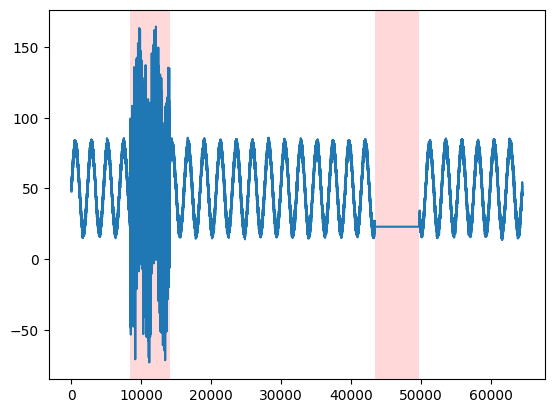

In [174]:
########################추론의 입력 데이터 정하기########################
predict_in_data = pd.concat([erratic_datas[:4032*8],stuck_datas[:4032*8]],ignore_index=True)  #pd.concat([erratic_datas[:4032*8],hardover_datas[:4032*8]],ignore_index=True)

plt.plot(predict_in_data["value"])

# error값인경우 배경 빨강색
timeseries_data = [i for i in range(len(predict_in_data))]
for i in range(len(predict_in_data)):
    if predict_in_data['error'][i] != 0:
        plt.axvspan(xmin=timeseries_data[i] - 0.5, xmax=timeseries_data[i] + 0.5, facecolor='red', alpha=0.15)

# 그래프 표시
#plt.ylim(0,100)
plt.show()

In [175]:
############################### 추론 ##############################
X_LSTM_test,y_LSTM_test = X_to_XyLSTM_shape(predict_in_data['value'],n_time_in,ntime_after)
y_LSTM_predict = LSTM_model_signal1.predict(X_LSTM_test,verbose=0)
"""
i= 5
print("입력 X\n",X_LSTM_test[i])
print("입력 y\n",y_LSTM_test[i])
print("추론 y\n",y_LSTM_predict[i])
"""

'\ni= 5\nprint("입력 X\n",X_LSTM_test[i])\nprint("입력 y\n",y_LSTM_test[i])\nprint("추론 y\n",y_LSTM_predict[i])\n'

오차 비교

In [176]:
def MSE(target,predict):
    return (1.0/2.0)*(target-predict)**2

In [177]:
input_size = len(predict_in_data["value"]) #입력된 데이터의 크기
test_size = len(y_LSTM_predict) # 테스트 데이터 크기 = 추론 데이터 크기 = 입력된 데이터의 크기 - (ntime_after+n_time_in)

In [178]:
# 예측은 학습 데이터(timeseries_data)보다 ntime_after+n_time_in 뒤꺼예측하므로 plt 그림 그릴 때 구간 맞춰주려고
real_time = [i for i in range(input_size)]
predict_time = [i-1 for i in range(ntime_after+n_time_in,input_size)] # i-1
"""
print(input_size)
print(len(real_time))#input_size == len(real_time) 여야함
print(test_size) 
print(len(predict_time)) #test_size == len(predict_time) 여야함
print("start predict index", predict_time[0]) # 예측 시작 index
"""

64512
64512
64383
64383
start predict index 128


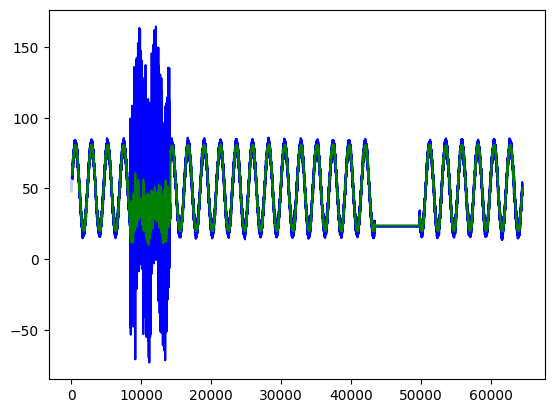

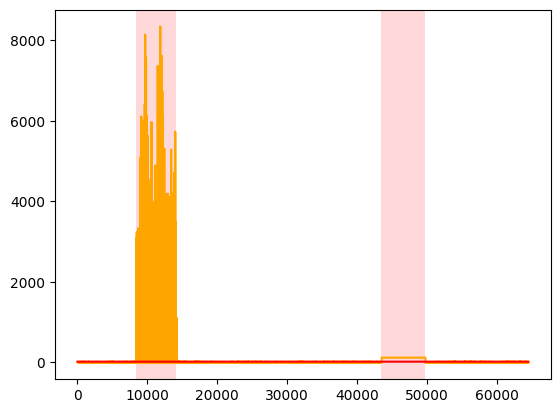

In [195]:
# sutck data 보완

#예측 input data
plt.plot(predict_in_data["value"],c='blue', alpha=0.2) #입력되는 시계열 data
# 타겟 data
plt.plot(predict_time,y_LSTM_test,c='blue') # 타겟 data
#예측 output data
plt.plot(predict_time,y_LSTM_predict,c='green') #추론 결과
plt.show()
plt.close()

threshold = 20
#stuck mse 부분 보정
mse = MSE(y_LSTM_test,y_LSTM_predict)
i = 0
stuck_start = "init"
while (i<len(mse)-2): #3개 비교 하므로 -2
    if(mse[i]==mse[i+1] and mse[i+1]==mse[i+2]):
        stuck_start = i
        while mse[i]==mse[i+1] and mse[i+1]==mse[i+2] :
            i += 1
        stuck_finish = i
    i += 1
if(stuck_start!= "init"): #초기값이 있다면 stuck구간이 존재하므로 mse를 바꿔야 함
    mse[stuck_start:stuck_finish] = threshold+100
#타겟 예측 MSE
plt.plot(predict_time,mse,c='orange')
#threshold 그래프
plt.plot([threshold for i in range(input_size)],c='red')
#오류부분 색칠
for i in range(len(predict_in_data)):
    if predict_in_data['error'][i] != 0:
        plt.axvspan(xmin=timeseries_data[i] - 0.5, xmax=timeseries_data[i] + 0.5, facecolor='red', alpha=0.15)
plt.show()
plt.close()


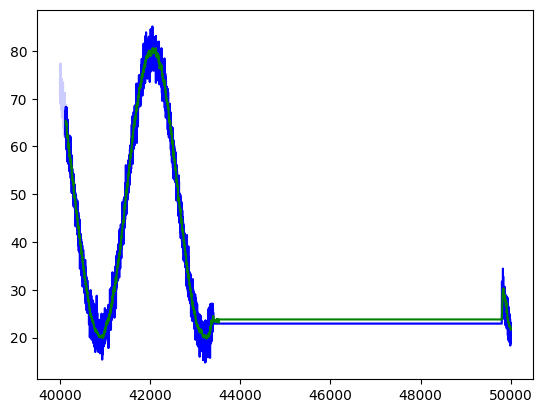

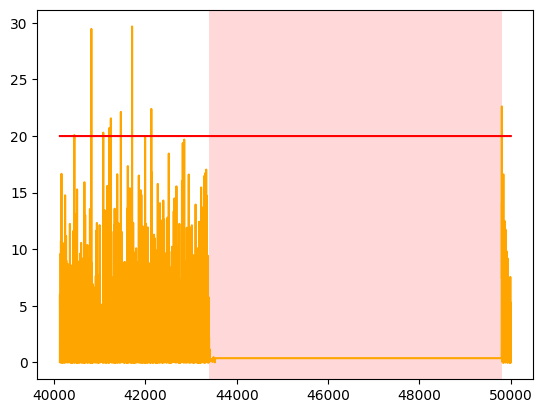

In [196]:
# 확대해서 보기
start =40000
finish = 50000
#예측 input data
plt.plot(real_time[start:finish],predict_in_data["value"][start:finish],c='blue', alpha=0.2) #입력되는 시계열 data
# 타겟 data
plt.plot(predict_time[start:finish-n_time_in],y_LSTM_test[start:finish-n_time_in],c='blue') # 타겟 data
#예측 output data
plt.plot(predict_time[start:finish-n_time_in],y_LSTM_predict[start:finish-n_time_in],c='green') #추론 결과
plt.show()
plt.close()

#타겟 예측 MSE
plt.plot(predict_time[start:finish-n_time_in],MSE(y_LSTM_test,y_LSTM_predict)[start:finish-n_time_in],c='orange')

#threshold 그래프
plt.plot(predict_time[start:finish-n_time_in],[threshold for i in range(input_size)][start:finish-n_time_in],c='red')
#오류부분 색칠
for i in range(start,finish):
    if predict_in_data['error'][i] != 0:
        plt.axvspan(xmin=timeseries_data[i] - 0.5, xmax=timeseries_data[i] + 0.5, facecolor='red', alpha=0.15)
plt.show()
plt.close()

In [197]:
#오류 시작과 끝
i = 0
while i < test_size:
    if predict_in_data['error'][i] != 0:
        print("start",i)
        while predict_in_data['error'][i] != 0:
            i = i+1
        print("finish",i)
    i = i + 1

start 8448
finish 14048
start 43400
finish 49800


In [198]:
###### 수동으로 구간 정해줘야 함 ######

# 에러 없는 구간
print("에러 없는 구간")
loss = LSTM_model_signal1.evaluate(X_LSTM_test[0:8000], y_LSTM_test[0:8000])
loss = LSTM_model_signal1.evaluate(X_LSTM_test[15000:30000], y_LSTM_test[15000:30000])
# 에러 구간
print("에러 구간")
loss = LSTM_model_signal1.evaluate(X_LSTM_test[9000:14000], y_LSTM_test[9000:14000])
print("sutck이므로 .evaluate로 평가시 낮게 나옴")
loss = LSTM_model_signal1.evaluate(X_LSTM_test[44000:49000], y_LSTM_test[44000:49000])

에러 없는 구간
469/469 [==============================] - 11s 24ms/step - loss: 4.2491
에러 구간
157/157 [==============================] - 4s 24ms/step - loss: 1557.9872
sutck이므로 .evaluate로 평가시 낮게 나옴
157/157 [==============================] - 4s 24ms/step - loss: 0.7600


In [199]:
# Stuck 에러 상태에서 값이 일정한지 확인하기 위해
"""
for i in range(17544-20,17544,1):
    print(y_LSTM_predict[i-n_time_in])
"""

'\nfor i in range(17544-20,17544,1):\n    print(y_LSTM_predict[i-n_time_in])\n'

In [200]:
print("threshold",threshold)

cnt = 0
start = 8448 #
finish = 14048 #
for i in range(start,finish):
    if mse[i] > threshold:
        cnt += 1
print("=======================")
print("erratic_datas")
print("Recall",round(100*cnt/(finish-start),2))

cnt = 0
start = 43400 #
finish = 49800 #
for i in range(start,finish):
    if mse[i] > threshold:
        cnt += 1
print("=======================")
print("stuck_datas")
print("Recall",round(100*cnt/(finish-start),2))


cnt = 0
predict_cnt = 0
for i in range(test_size):
    if mse[i] > threshold:
        predict_cnt+= 1
        if predict_in_data['error'][i] != 0:
            cnt+=1
print("=======================")
print("total_datas")
if predict_cnt != 0:
    print("Precision",round(100*cnt/predict_cnt,2))
else:
    print("Error predict count : 0")

threshold 20
erratic_datas
Recall 86.95
stuck_datas
Recall 98.0
total_datas
Precision 97.98
